In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

# Задача
Решить методом Тейлора 2-го порядка задачу Коши
$$
 y^{''} + y = x\exp(-x), \ y(0) = 1, y^{'}(0) = 0, x \in [0, 2]
$$

с заданной точнотью 0.01.

Построить графики $y(x), y^{'}(x)$, а также фазовых траекторий.

# Теоретическая часть

Решим более общую задачу, а именно

$$
y^{(n)} = f(x, y^{'}, \dots, y^{(n-1)}); \ \ (y(a), y^{'}(a), \dots, y^{(n-1)}(a)) = (a_0, \dots, a_{n-1}); \ \ x\in [a, b]
$$

Разобьем на $m$ частей (достаточно мелко, подробнее как именно будет рассказано ниже) интервал $[a, b]$. Тогда, используя приближение при помощи формулы Тейлора, отбросив слагаемые третьего порядка и выше, мы можем записать следующее равенство

$$
y^{(k)}(x_i) = y^{(k)}(x_{i-1}) + (x_i - x_{i-1})y^{(k+1)}(x_{i-1}) + \frac{(x_i - x_{i-1})^2}{2}y^{(k+2)}(x_{i-1})
$$

Такая формула задает алгоритм вычисления функции $y$ и ее производных (до $n$ включительно), последовательно от точки к точке: мы вычисляем значение вектора производных в точке $x_i$ через значения вектора производных в точке $x_{i-1}$.

Единственная проблема в вычислении $y^{(n)}$ и $y^{(n-1)}$, так как согласно формуле выше, их вычисление опирается на знание $y^{(n+1)}$ и $y^{(n+2)}$ в точке $x_{i-1}$.

Значение $y^{(n)}(x_i)$ вычислим согласно уравнению из условия нашей задачи:
$$
y^{(n)}(x_i) = f(x_i, y^{'}(x_i), \dots, y^{(n-1)}(x_i))
$$

и вычисляем мы значение $n$-ой производной, основываясь на вычисленных значениях младших производных в точке $x_{i}$.
Значение $y^{(n+1)}(x_{i-1})$ считается так:
$$
y^{(n+1)}(x_{i-1}) = \frac{\partial f}{\partial s_0} + \sum_{j=1}^{n-1}\frac{\partial f}{\partial s_j}y^{(j)}
$$
частные производные беруться по $j$-му аргументу функции $f$, все выражение вычисляется в точке $x_{i-1}$.


### Метод выбора решетки $\{x_{i}\}$

По данному $\epsilon$ мы измельчаем решетку в 2 раза до тех пор, пока норма $||y^i - y^{i-1}||$ в $C^{n}[a, b]$ не станет меньше $\epsilon$ (здесь $y^{i}$ и $y^{i-1}$ -- решения посчитанные для решеток на $i$-ом и $(i-1)$-ом шаге)

# Практическая часть

Для решения задачи был написан класс TeylorMethod, позволяющий решать описанную выше задачу. Основной метод в этом классе 

$$
std::vector<std::vector<float>> compute(
            std::function<float(std::vector<float>&)>& f,
            float a,
            float b,
            std::vector<float>& y0,
            std::vector<std::function<float(std::vector<float>&)>>& partials,
            int n_init=10,
            double eps=0.01)
$$

опирающийся на приватные методы

$$
std::vector<std::vector<float>> _teylor_method(
            std::function<float(std::vector<float>&)>& f,
            std::vector<float>& grid,
            std::vector<float>& y0,
            std::vector<std::function<float(std::vector<float>&)>>& partials)
$$ 
реализующий метод Тейлора при заданном разбиении интервала $[a, b]$ и

$$
std::vector<float> _get_optimal_grid(
             std::function<float(std::vector<float>&)>& f,
             float a,
             float b,
             std::vector<float>& y0,
             std::vector<std::function<float(std::vector<float>&)>>& partials,
             int n_init=10,
             double eps=0.01)
$$
для поиска оптимального разбиения интервала.


Используя этот класс, программа считает решения данного уравнения, а так же произовдные до $n$ включительно и записывает результат в файл "teylor_output.csv".

## Результаты

Для проверки правильности решения, приведем аналитическое решение нашей задачи:
$$
y = \frac{1}{2}\cos(x) + \frac{1}{2}xe^{-x} + \frac{1}{2}e^{-x}
$$

In [12]:
result = pd.read_csv('cmake-build-debug/teylor_output.csv', header=None).T

In [13]:
result.head()

,0,1,2,3
0,0.00,1.000000,0.000000,-1.000000
1,0.05,1.000000,-0.048750,-0.952439
2,0.10,0.997563,-0.095181,-0.907079
3,0.15,0.992803,-0.139398,-0.863697
4,0.20,0.985834,-0.181495,-0.822087


In [36]:
# функция из условия задачи
def f(args):
    return -args[1] + args[0]*np.exp(-args[0])

# частные производные
partials = [
    lambda args: -args[0]*np.exp(-args[0]) + np.exp(-args[0]),
    lambda args: -1,
    lambda args: 0
]

# начальные условия
y0 = [1, 0]

# точное решение
def sol(x):
    return 0.5*np.cos(x) + 0.5*x*np.exp(-x) + 0.5*np.exp(-x)

# производная
def dsol(x):
    return -0.5*np.sin(x) - 0.5*x*np.exp(-x)


Реализуем так же метод Тейлора на питоне, но не будем заморачиваться с выбором сетки, нам эта функция нужна лишь для валидации, возьмем не слишком плотную сетку, чтоб не сливались графики

In [37]:
def teylor(f, grid, y0, partials):
    result = np.zeros(shape=(len(partials), len(grid)))
    for i in range(len(y0)):
        result[i][0] = y0[i]
    result[-1][0] = f([grid[0]] + list(y0))
    
    for i in range(1, len(grid)):
        step = grid[i] - grid[i-1]
        
        for j in range(result.shape[0] - 1):
            result[j][i] = result[j][i-1] + step*result[j+1][i-1]
        
        result[-1][i] = f([grid[i]] + [result[j][i] for j in range(result.shape[0] - 1)])
    
    return [grid] + list(result)
    

In [42]:
presult = neuton_rafson(f, np.arange(0, 2, 0.05), y0, partials)

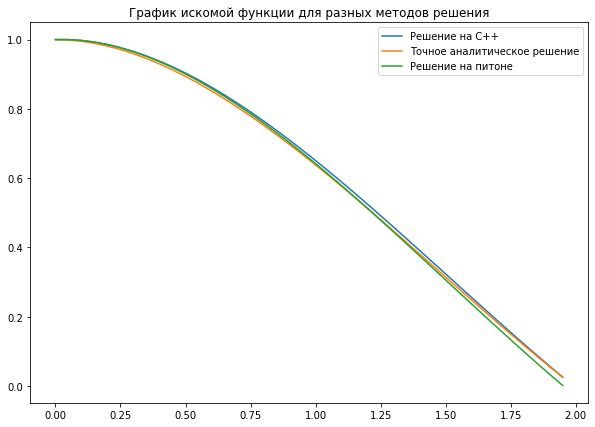

In [43]:
plt.figure(figsize=(10, 7))
plt.title("График искомой функции для разных методов решения")
plt.plot(result[0], result[1], label='Решение на C++')
plt.plot(result[0], result[0].apply(sol), label='Точное аналитическое решение')
plt.plot(presult[0], presult[1], label='Решение на питоне')
plt.legend()

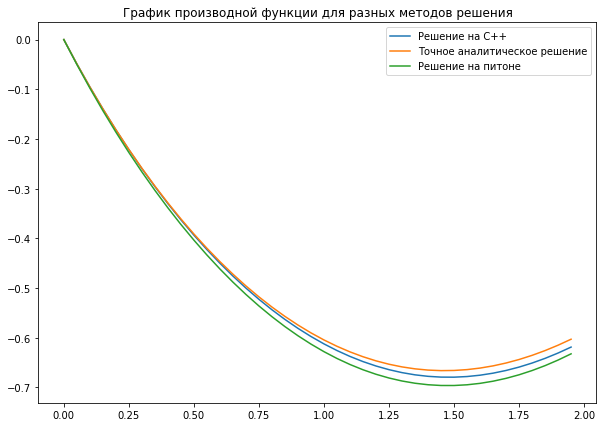

In [44]:
plt.figure(figsize=(10, 7))
plt.title("График производной функции для разных методов решения")
plt.plot(result[0], result[2], label='Решение на C++')
plt.plot(result[0], result[0].apply(dsol), label='Точное аналитическое решение')
plt.plot(presult[0], presult[2], label='Решение на питоне')
plt.legend()